In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [3]:
np.random.seed(2020)
tf.random.set_seed(2020)

dataset = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = dataset.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
## Hyperparameters
H = 28
W = 28
C = 1

## Latent space
latent_dim = 128

In [5]:
inputs = Input(shape=(H, W, C), name="inputs")
x = inputs

### Encoder

In [6]:
x = Conv2D(32, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)

### Latent space

In [7]:
x = Flatten()(x)
units = x.shape[1]
x = Dense(latent_dim, name="latent")(x)
x = Dense(units)(x)
x = LeakyReLU(alpha=0.2)(x)

In [8]:
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(1, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("sigmoid", name="outputs")(x)

outputs = x

### Decoder

In [9]:
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss=tf.keras.losses.MeanAbsoluteError())
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256   

In [10]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    shuffle=False,
    validation_data=(x_test, x_test)
)

Epoch 1/50
235/235 [==============================] - 9s 39ms/step - loss: 0.2123 - val_loss: 0.2736
Epoch 2/50
235/235 [==============================] - 9s 37ms/step - loss: 0.1548 - val_loss: 0.1469
Epoch 3/50
235/235 [==============================] - 9s 38ms/step - loss: 0.1208 - val_loss: 0.1065
Epoch 4/50
235/235 [==============================] - 9s 37ms/step - loss: 0.0979 - val_loss: 0.0883
Epoch 5/50
235/235 [==============================] - 9s 38ms/step - loss: 0.0822 - val_loss: 0.0768
Epoch 6/50
235/235 [==============================] - 9s 38ms/step - loss: 0.0710 - val_loss: 0.0661
Epoch 7/50
235/235 [==============================] - 9s 38ms/step - loss: 0.0627 - val_loss: 0.0587
Epoch 8/50
235/235 [==============================] - 9s 38ms/step - loss: 0.0564 - val_loss: 0.0532
Epoch 9/50
235/235 [==============================] - 9s 38ms/step - loss: 0.0515 - val_loss: 0.0495
Epoch 10/50
235/235 [==============================] - 9s 38ms/step - loss: 0.0478 - val_lo

In [13]:
test_pred_y = autoencoder.predict(x_test)

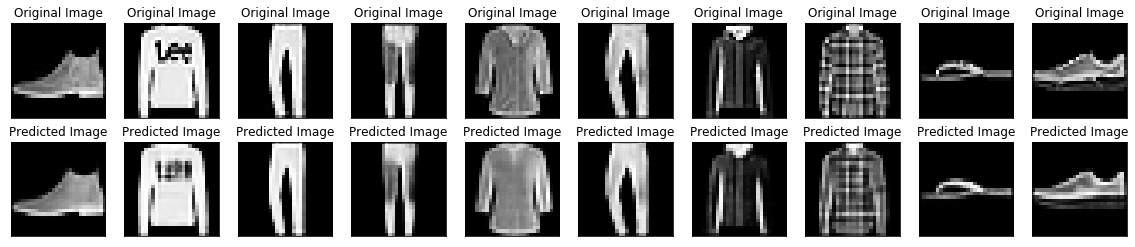

In [12]:
n = 10  ## how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ## display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title("Original Image")
    plt.imshow(x_test[i].reshape(H, W))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ## display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title("Predicted Image")
    plt.imshow(test_pred_y[i].reshape(H, W))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("result_CAE.png")